# Predicting 911 call category

911 is the number most people in the U.S. and some other countries call to get help in a police, fire or medical emergency. An emergency is a life-threatening situation where every second counts, such as a heart attack, child birth in progress, uncontrolled fire, a life-threatening event such as a knife fight, an armed robbery in progress, or a serious car accident. In order to be effective, the emergency system needs to fulfill the following:

- Recognize when someone dials the emergency number on any phone.
- Route the call to the nearest answering point based on the call's originating location.
- Notify the appropriate agency as quickly as possible so it can respond to the emergency

An estimated of 240 million calls are made to 911 in the US each year (nena.org). However, 15%–20% of incoming 911 calls are non-emergencies (e.g. pranks, unintentional calls, etc.). These calls not only waste time and money, they can also be dangerous. If 911 lines or dispatchers are caught up with non-emergencies calls, the risks of not answering or delaying a legitimate emergency increase.

This project targets this situation and creates a model that predicts the category (e.g. robbery, medical, etc.) of a 911 call. This model can make predictions at the time the call is made and continues to do so as the call develops. 

Such a model can be used by different institutions involved in dealing with an emergency from different levels, such as the logistics, funding and deployments:

- City councils.
- Police, fire and medical departments.
- Telephone companies

In addition, from the perspective of the individual experiencing an emergency, it is possible that the likelihood that the emergency is being dealt with succesfully may increase. 


## Data

The dataset used for this projects targets 911 calls made during the first half of 2016 in the city of Detroit. This city was chosen because of its relatively mid-high population, 4.3 million in its metropolitan area, which could allow for this analysis to be extrapolated to other cities. 

The dataset can be found at the following URL:


https://data.world/detroit/detroit-911-calls


The data comes in a .csv file format. It contains 466260 records and 20 columns. The columns contain the following data types: string, integer, boolean and float. Four columns show empty values within them. 

The column 'category', corresponding to the 911 call category, will be the variable to be predicted. This variable contains 35 levels, among them 'accident', 'drugs', 'fire', 'prank/other', 'robbery', etc. The other 19 columns include different information regarding the incident location, call time and date, responding agency and priority codes, different times in dealing with the emergency (e.g. intake time, dispatch time), disposition towards the call and call description. The information contained in the variable call description is given in key words representing the event; no actual transcripts of the caller-dispatcher exchange are given. 

In [1]:
# Import required modules
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import seaborn as sns
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import h2o

# Load data and display dataframe and column names
Detroit = pd.read_csv('/Capstone project 1 - 911 calls/Detroit_911_calls.csv', encoding='latin-1')
print(Detroit.head())
print('Detroit columns:', sorted(Detroit.columns))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


        callno agency  priority                  incident_address callcode  \
0  HP160970008    DPD        50  WOODWARD AVE   MANCHESTER ST HPK   827050   
1   P161000007    DPD        20              6500 METTETAL ST DET   842020   
2   P160992496    DPD        22               1100 ASHLAND ST DET   843022   
3   P160992494    DPD        30      STOTTER ST   E 7 MILE RD DET   811030   
4   P160992493    DPD        50           3400 E MCNICHOLS RD DET     PKNC   

    calldescription            category calldate  calltime       disposition  \
0     DDOT/BOARDING   DISORDERLY PERSON   4/6/16   8:28:50  NO PROBLEM FOUND   
1  1 DWN/OVR WHL/OD  INVESTIGATE PERSON   4/8/16  23:59:55               NaN   
2  WANTD/WRNT FELON  INVESTIGATE PERSON   4/8/16  23:59:43               NCF   
3                 .            ACCIDENT   4/8/16  23:59:33               NaN   
4    HANG UP/PRANKS         PRANK/OTHER   4/8/16  23:59:12               NaN   

   precinctsca respondingunit  officerinitiated  i

In [2]:
# Inspect the dataset shape and the info stored in the columns
print(Detroit.shape)
print(Detroit.info())

(466260, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466260 entries, 0 to 466259
Data columns (total 20 columns):
callno              466260 non-null object
agency              466260 non-null object
priority            466260 non-null int64
incident_address    463368 non-null object
callcode            466260 non-null object
calldescription     466260 non-null object
category            466260 non-null object
calldate            466260 non-null object
calltime            466260 non-null object
disposition         265695 non-null object
precinctsca         390750 non-null float64
respondingunit      227425 non-null object
officerinitiated    466260 non-null bool
intaketime          466260 non-null float64
dispatchtime        466260 non-null float64
traveltime          466260 non-null float64
totresponsetime     466260 non-null float64
timeonscene         466260 non-null float64
totaltime           466260 non-null float64
location            466260 non-null object
dtypes: bool

In [3]:
# Call categories 
print(sorted(Detroit.category.unique()))
print('Number of call categories:', len(Detroit.category.unique()))

['31', '90', '93', '99', 'ACCIDENT', 'ALARM', 'ANIMAL', 'AR', 'ASSAULT', 'AUTO THEFT', 'BURGLARY', 'DISORDERLY PERSON', 'DRUGS', 'FAMILY TROUBLE', 'FIRE', 'INVESTIGATE PERSON', 'LARCENY', 'MEDICAL', 'OTHER', 'PRANK/OTHER', 'RA', 'RAPE', 'ROBBERY', 'SA', 'SI', 'SPECIAL DETAIL', 'SS', 'T', 'TI', 'TO', 'TRAFFIC', 'TS', 'W3', 'W5', 'W8']
Number of call categories: 35


## Methodology

### Data wrangling and cleaning

The data of the column 'priority' was changed from integer to string in order to reflect and be handled as categorical data. Missing values are filled with 0.


### Feature engineering

Additional features or variables were created in order to provide more fine-grained information with regard to the time and location of the emergency. Since the street and district of the emergency are contained in the 'incident_address' variable, a new variable was created to store the district information: 'district'. Similarly, from the 'location' variable, 'longitude' and 'latitude' variables were extracted. Features for 'year', 'month', and 'day' and 'hour', 'minute', and 'second' were extracted from the 'calldate' and 'calltime' variables, respectively.

In [4]:
# Convert the priority column to object
Detroit['priority'] = Detroit['priority'].astype(object)

# Fill missing values with 0
Detroit.disposition = Detroit.disposition.fillna(0)
Detroit.precinctsca = Detroit.precinctsca.fillna(0)
Detroit.respondingunit = Detroit.respondingunit.fillna(0)

In [5]:
# Extract the district information from the incident address column (eg. DET, HPK)

Detroit['incident_address'] = Detroit['incident_address'].astype(str)
Detroit['district'] = Detroit['incident_address'].apply(lambda x: x[-3:])

# Fill NA values in the column 'district'
Detroit.district = Detroit.district.fillna('XXXX')

# Create a new column for longitude and latitude from 'location' column

def longitude(string):
    '''Look at the values of a string and get the first group of digits containing a decimal, longitude'''
    long = re.findall(r"[-+]?\d*\.\d+", string)[0]
    return long


def latitude(string):
    '''Look at the values of a string and get the first group of digits containing a decimal, latitude'''
    try:
        lat = re.findall(r"[-+]?\d*\.\d+", string)[1]
        return lat
    except:
        return 0.0000

Detroit['longitude'] = Detroit['location'].apply(lambda x: longitude(x)).astype(np.float64)
Detroit['latitude'] = Detroit['location'].apply(lambda x: latitude(x)).astype(np.float64)

# Check if longitude has any negative values
'-' in Detroit['longitude']

# Extract data and hour values and create columns with them

Detroit['calldate'] = pd.to_datetime(Detroit['calldate']) 
Detroit['calltime'] = pd.to_datetime(Detroit['calltime']) 

Detroit['year'] = Detroit['calldate'].apply(lambda x: x.year)
Detroit['month'] = Detroit['calldate'].apply(lambda x: x.month)
Detroit['day'] = Detroit['calldate'].apply(lambda x: x.day)

Detroit['hour'] = Detroit['calltime'].apply(lambda x: x.hour)
Detroit['minute'] = Detroit['calltime'].apply(lambda x: x.minute)
Detroit['second'] = Detroit['calltime'].apply(lambda x: x.second)

## Exploratory data analysis

The present dataset is imbalanced; one level of the target variable corresponds to 45.3% of the observations whereas 25 out of the 35 levels each represent 1% or less of it.

The most frequent category of 911 calls in this dataset is 'prank/other' with 45.3% of the observations. This amounts to more than double of the previously reported rate of prank calls. This situation can potentially be costly and dangerous as prank calls are consuming almost half of the resources assigned to attending the emergencies. The next two most attested categories are 'investigate person' and 'family trouble' with 7.2% and 7.1%, respectively.

Almost all of the calls analyzed here were directed to the Detroit Police Department 'DPD' (94.4%). Thus, there does not seem to be a relationship between the 911 call 'category' and the 'agency' that responded to it.

The most frequent emergency 'code' assigned to the calls was '50', corresponding to traffic accident. This outcome was unexpected because traffic-related emergencies appear at posiiton 14th of the most frequent call 'categories'. However, upon further scrutiny, the reason behind this is that the majority of the most frequent category 'prank/others' were assigned to the priority call '50'. The next most frequent priority codes were '30' for unnecssary use of radio and '20' for location. These call priority codes are attested throughout different call 'categories' sugesting a lack of relationship between them.

911 calls occur least frequently between 4:00am and 5:00am presumably because people are still sleeping. After that point, the number of 911 calls increases reaching its highest point in the period between 4:00pm - 6:00pm, which corresponds to the time were people finish worrk and travel back home. Then, the number of emergency calls decreases throughout the night and early hours of the morning until reaching the lowest point in frequency. With regard to the three most frequent 911 call categories, 'prank/other' calls occur more frequently at 7:00am and noon; although they are highly attested throughout the day as well. As for 'investigate person' and 'family trouble' calls, they do not show a clear preference for a particular hour in the day. 

There are no major variations with regard to the frequency of 911 calls with respect to the month they take place. Furthermore, the 911 call categories do not show a preference or lack thereof for a given month to spike their frequency.

The majority of the 911 calls were initiated by non-police officers. However, certain call 'categories' such 'SA', 'TS', and 'T' were exclusively initiated by a member of the police department, suggesting that this feature may be useful in distinguish two broad types of 911 call categories. 

The majority of the 911 calls are ingested in one to three minutes with certain variation. However, a couple of categories such as 'fire', 'AR', and 'other' tend to be shorter than the average; this could be related to the facility in describing the emergency, e.g. a fire. 

The remaining variables, such as 'traveltime', 'totresponsetime' and 'timeonscene', will not be discussed here because the event they represent occurs only after the emergency call has been completed. The investigation of a possible relationship between call 'category' and 'location' still needs further research and will be further discussed in the future research section. A similar discussion will be carried out in the future research section for the possibility of using the information stored in the variable 'call description' to make better predictions. 

Text(0.5,1,'Call categories percentage')

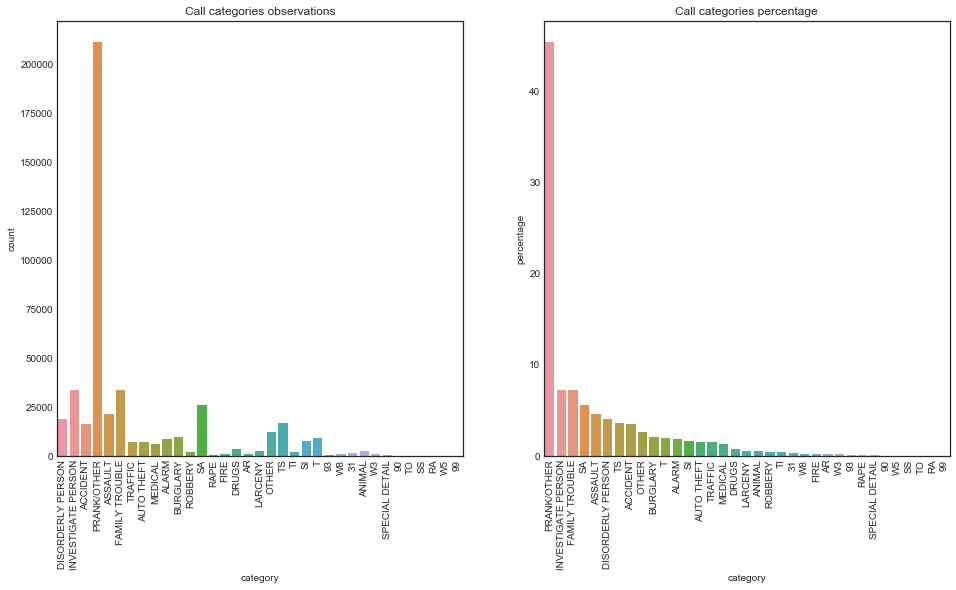

In [6]:
# Obtain value counts and percentages of level of target variable
counts = Detroit['category'].value_counts()
percentage = []

for i in counts:
    valor = i * 100 / len(Detroit)
    percentage.append(valor)

# Create dataframe with value counts and corresponding percentanges for target variable categories
observations = pd.DataFrame(counts)
observations['percentage'] = percentage
observations.columns.values[0] = 'observations'
observations['category'] = observations.index
observations = observations.reset_index(drop=True)

# Make subplots
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
ax1= sns.countplot(x=Detroit.category)
plt.xticks(rotation=90)
ax1.set_title('Call categories observations')
#ax1 = Detroit['category'].value_counts().plot(kind='bar').set_title('Call categories distribution')
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='category', y='percentage', data=observations)
plt.xticks(rotation=90)
ax2.set_title('Call categories percentage')

DPD     439964
WSPD     21151
HPP       5145
Name: agency, dtype: int64

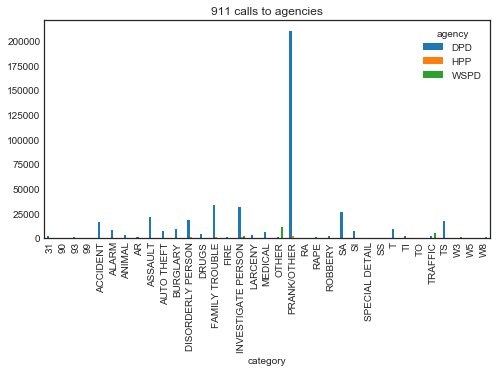

In [7]:
# Category and agency
Detroit.groupby(['category', 'agency']).size().unstack().plot.bar(figsize=(8, 4)).set_title('911 calls to agencies')
Detroit['agency'].value_counts()

(0, 40000)

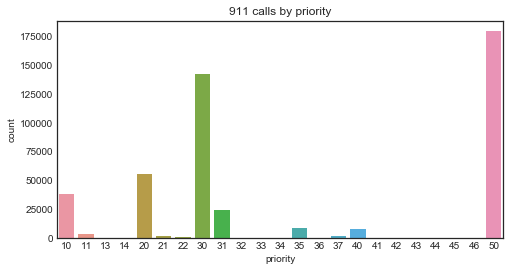

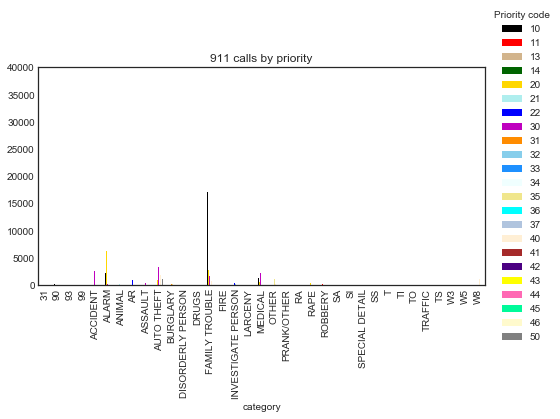

In [8]:
# Category and priority

plt.figure(figsize=(8, 4))
ax4 = sns.countplot(Detroit.priority)
ax4.set_title('911 calls by priority')

colors = ['black', 'red', 'tan', 'darkgreen', 'gold', 'paleturquoise', 'blue', 'm', 'darkorange', 'skyblue', 'dodgerblue', 'azure', 'khaki', 'aqua', 'lightsteelblue', 'papayawhip', 'brown', 'indigo', 'yellow', 'hotpink', 'mediumspringgreen', 'lemonchiffon', 'grey']
Detroit.groupby(['category', 'priority']).size().unstack().plot.bar(figsize=(8, 4), color=colors).set_title('911 calls by priority')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Priority code')
plt.ylim(0, 40000)

Text(0.5,1,'911 call per hour per category')

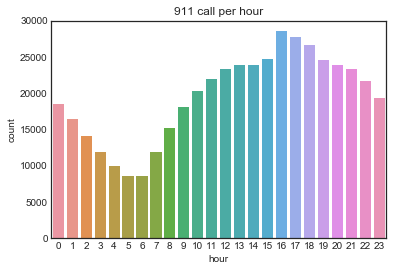

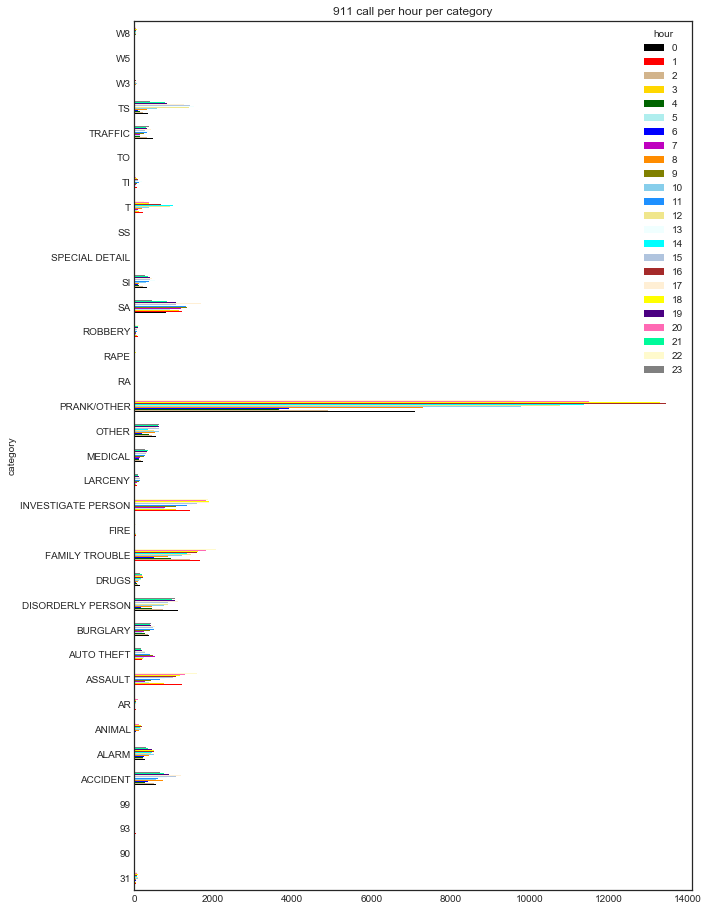

In [9]:
# Category and hour
ax6 = sns.countplot(Detroit.hour)
ax6.set_title('911 call per hour')
colors = ['black', 'red', 'tan', 'gold', 'darkgreen', 'paleturquoise', 'blue', 'm', 'darkorange', 'olive', 'skyblue', 'dodgerblue', 'khaki', 'azure', 'aqua', 'lightsteelblue', 'brown', 'papayawhip', 'yellow', 'indigo', 'hotpink', 'mediumspringgreen', 'lemonchiffon', 'grey']
Detroit.groupby(['category', 'hour']).size().unstack().plot.barh(color=colors, figsize=(10, 16)).set_title('911 call per hour per category')

Text(0.5,1,'911 calls per month per category')

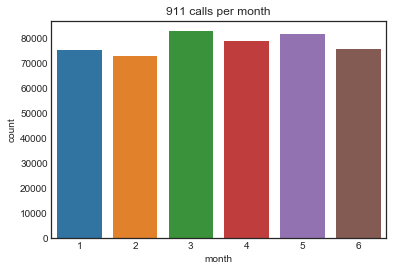

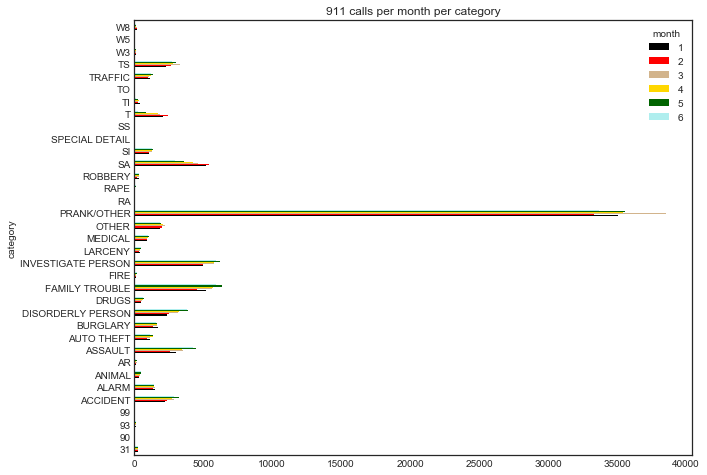

In [10]:
# Category and month
ax7 = sns.countplot(Detroit.month)
ax7.set_title('911 calls per month')
Detroit.groupby(['category', 'month']).size().unstack().plot.barh(color=colors, figsize=(10, 8)).set_title('911 calls per month per category')

Text(0,0.5,'count')

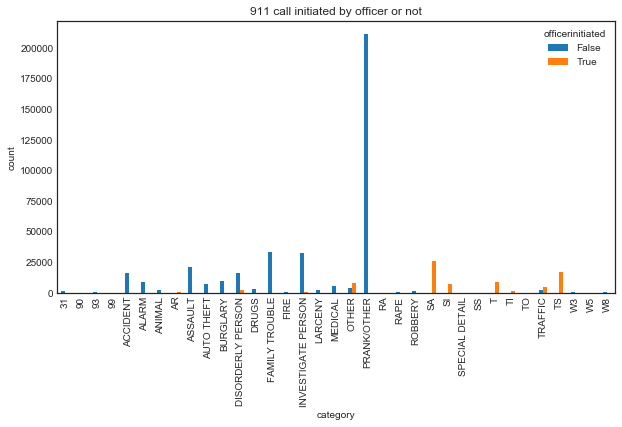

In [11]:
# Category and officer initiated
ax8 = Detroit.groupby(['category', 'officerinitiated']).size().unstack().plot.bar(figsize=(10, 5))
ax8.set_title('911 call initiated by officer or not')
plt.ylabel('count')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

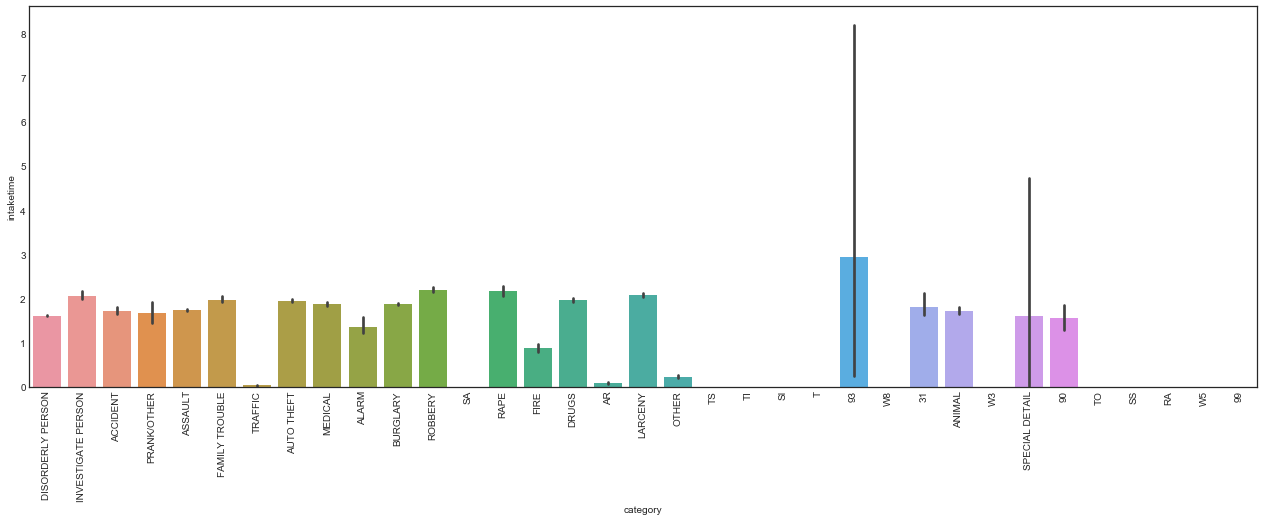

In [12]:
# Category and intaketime
plt.figure(figsize=(22, 7))
sns.barplot(x="category", y="intaketime", data=Detroit)
plt.xticks(rotation=90)